In [298]:
%matplotlib inline
import matplotlib.pyplot as plt
from __future__ import print_function
import nltk
from nltk import sent_tokenize
from collections import Counter
import pandas as pd
import numpy as np

In [299]:
# pos tag information 
from nltk.data import load
tagdict = load('help/tagsets/upenn_tagset.pickle')

In [300]:
# preparing feature set
questionTriples = ['CD-VB-VBN',
                   'MD-PRP-VB' ,
                   'MD-VB-CD' ,
                   'NN-IN-DT' ,
                   'PRP-VB-PRP' ,
                   'PRP-WP-NNP' ,
                   'VB-CD-VB' ,
                   'VB-PRP-WP' ,
                   'VBZ-DT-NN' ,
                   'WP-VBZ-DT' ,
                   'WP-VBZ-NNP' ,
                   'WRB-MD-VB']

statementTriples = ['DT-JJ-NN',
                   'DT-NN-VBZ',
                   'DT-NNP-NNP',
                   'IN-DT-NN',
                   'IN-NN-NNS',
                   'MD-VB-VBN',
                   'NNP-IN-NNP',
                   'NNP-NNP-NNP',
                   'NNP-VBZ-DT',
                   'NNP-VBZ-NNP',
                   'NNS-IN-DT',
                   'VB-VBN-IN',
                   'VBZ-DT-JJ']


startTuples = ['NNS-DT',
               'WP-VBZ',
               'WRB-MD']                      

endTuples = ['IN-NN',
             'VB-VBN',
             'VBZ-NNP'] 

features = questionTriples + statementTriples + startTuples + endTuples

In [88]:
def do_spacy(sentences):
    import spacy
    sp_en = spacy.load('en')
    X_train_sp = []
    for sentence in sentences:
        X_train_sp += [' '.join([x.lemma_ for x in sp_en(unicode(sentence))])]
    print ("Before :", sentences[0])
    print ("After :", X_train_sp[0])
    return X_train_sp
def do_vectorize(x_train):
    from sklearn.feature_extraction.text import CountVectorizer
    cv = CountVectorizer(stop_words='english',min_df=5)
    bow = cv.fit_transform(x_train)
    return bow.toarray()

In [215]:
def get_pos_df(sentences):
    dic_pos = {k:[] for k in features}
    dic_pos['id'] = []
    for n,s in enumerate(sentences):
        pos_list = nltk.pos_tag(s.split())
        postag_list = [x[1] for x in pos_list]
        d = {}
        for i, postag in enumerate(postag_list):
            try:
                tri = postag + '-' + postag_list[i+1] + '-' + postag_list[i+2]
                try:
                    d[tri] += 1
                except KeyError:
                    d[tri] = 1
            except IndexError:
                pass
            
            try:
                di = postag + '-' + postag_list[i+1]
                try:
                    d[di] += 1
                except KeyError:
                    d[di] = 1
            except IndexError:
                pass
            
        #d = Counter(postag_list)
        dic_pos['id'].append(str(n))
        for feature in features:
            try:
                dic_pos[feature].append(d[feature])
            except KeyError:
                dic_pos[feature].append(0)
    df = pd.DataFrame(dic_pos)
    return df
    

In [8]:
f = open('./pubmed_result_climate_change_korea.txt')
fr = f.read()

abstracts = []
for each in fr.split('\r\n\r\n\r\n'):
    for n,l in enumerate(each.split('\r\n\r\n')):
        key = 'Author information:'
        if l[0:len(key)] == key:
            abstracts.append(each.split('\r\n\r\n')[n+1].strip().replace('\r\n',' '))

In [ ]:
sentences = []
for abstract in abstracts:
    sentences += sent_tokenize(abstract.decode("utf8"))

In [79]:
sentences_sp = do_spacy(sentences)

Before : The Holocene variability in the East Asian summer monsoon (EASM) based on speleothem δ(18)O records has inconsistencies in timing, duration, and expression of millennial-scale events among nearby regions, and even within the same cave.
After : the holocene variability in the east asian summer monsoon ( easm ) base on speleothem δ(18)o record have inconsistency in time , duration , and expression of millennial - scale event among nearby region , and even within the same cave .


In [89]:
x_train_sp_bow = do_vectorize(sentences_sp)

In [263]:
# sentence to pos 
df_allsent_pos = get_pos_df(sentences)

In [264]:
x_allsent_pos = df_allsent_pos.values[:,:-1]

In [265]:
tsne = TSNE()
x_allsent_pos_tsne = tsne.fit_transform(x_allsent_pos)

In [266]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=20,random_state=0)
cluster = km.fit_predict(x_allsent_pos_tsne)

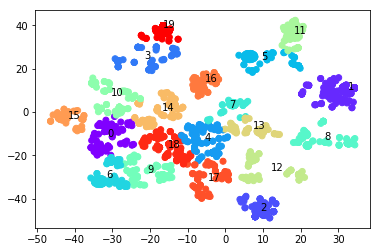

In [267]:
plt.scatter(x_allsent_pos_tsne[:,0],x_allsent_pos_tsne[:,1],c=cluster,cmap='rainbow')
for x,y in zip(km.cluster_centers_,range(0,km.cluster_centers_.shape[0])):
    plt.text(x[0],x[1],y)

In [270]:
m = km.labels_ == 2
np.array(sentences)[m]

array([ u'Coccophora langsdorfii (Turner) Greville (Fucales) is an intertidal brown alga that is endemic to Northeast Asia and increasingly endangered by habitat loss and climate change.',
       u'The circular plastid genome is 124,450 bp and contains 139 protein-coding, 28 tRNA and 6 rRNA genes.',
       u'Using a time-series design and piecewise linear regression models, we estimated the percentage change in AKI admissions associated with daily mean temperature after controlling for relevant  covariates.',
       u'Biomass fraction data did not show a normal distribution.',
       u'In addition, FA assimilation via FDH was found to be more efficient than the reverse reaction of PFL.',
       u'Haemaphysalis longicornis is the only species of tick present in New Zealand which infests livestock and is also the only competent vector for Theileria orientalis.',
       u'A rule-based climate envelope model was developed based on the environmental requirements for off-host tick survival.'

In [271]:
df_allsent_pos[m].head()

,CD-VB-VBN,DT-JJ-NN,DT-NN-VBZ,DT-NNP-NNP,IN-DT-NN,IN-NN,IN-NN-NNS,MD-PRP-VB,MD-VB-CD,MD-VB-VBN,...,VB-VBN-IN,VBZ-DT-JJ,VBZ-DT-NN,VBZ-NNP,WP-VBZ,WP-VBZ-DT,WP-VBZ-NNP,WRB-MD,WRB-MD-VB,id
35,0,1,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,35
37,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,37
59,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,59
80,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,80
145,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,145


In [272]:
tagdict['DT']

('determiner',
 'all an another any both del each either every half la many much nary neither no some such that the them these this those ')

In [273]:
tagdict['JJ']

('adjective or numeral, ordinal',
 'third ill-mannered pre-war regrettable oiled calamitous first separable ectoplasmic battery-powered participatory fourth still-to-be-named multilingual multi-disciplinary ... ')

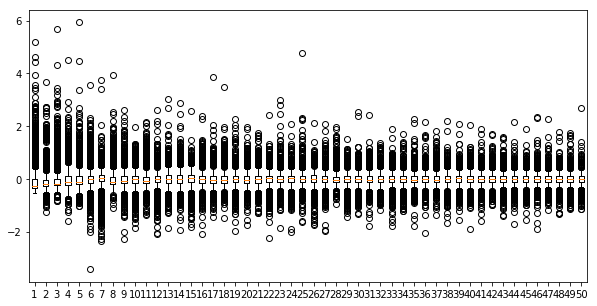

In [182]:
# 어떤 구분을 보이는지 보자. 
## PCA decomposition 
from sklearn.decomposition import PCA
plt.figure(figsize=(10,5))
pca = PCA(n_components=50)
X_pca_pos = pca.fit_transform(x_train_sp_bow)

plt.boxplot(X_pca_pos)
plt.show()

In [120]:
from sklearn.manifold import TSNE

In [122]:
tsne = TSNE()
X_pca_bow_tsne = tsne.fit_transform(X_pca_bow)

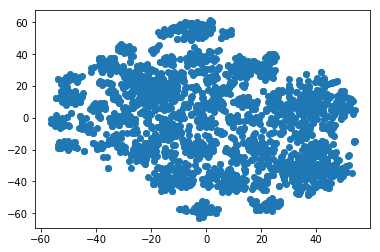

In [123]:
plt.scatter(X_pca_bow_tsne[:,0],X_pca_bow_tsne[:,1])

In [169]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=20,random_state=0)
cluster = km.fit_predict(X_pca_bow_tsne)

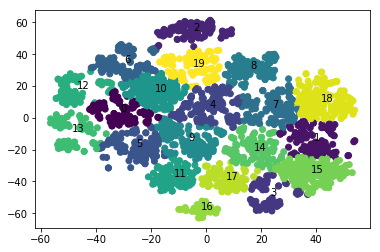

In [170]:
plt.scatter(X_pca_bow_tsne[:,0],X_pca_bow_tsne[:,1],c=cluster)
for x,y in zip(km.cluster_centers_,range(0,km.cluster_centers_.shape[0])):
    plt.text(x[0],x[1],y)

In [197]:
m = km.labels_ == 19

In [198]:
sub_sentences = np.array(sentences_sp)[m]

In [216]:
df_pos = get_pos_df(sub_sentences)

In [217]:
df_pos.head()

,CD-VB-VBN,DT-JJ-NN,DT-NN-VBZ,DT-NNP-NNP,IN-DT-NN,IN-NN,IN-NN-NNS,MD-PRP-VB,MD-VB-CD,MD-VB-VBN,...,VB-VBN-IN,VBZ-DT-JJ,VBZ-DT-NN,VBZ-NNP,WP-VBZ,WP-VBZ-DT,WP-VBZ-NNP,WRB-MD,WRB-MD-VB,id
0,0,0,0,0,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,2,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
4,0,2,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [218]:
X_sub = df_pos.values[:,:-1]

In [219]:
X_sub.shape

(148, 31)

In [220]:
tsne = TSNE()
X_sub_tsne = tsne.fit_transform(X_sub)

In [225]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=20,random_state=0)
cluster = km.fit_predict(X_sub_tsne)

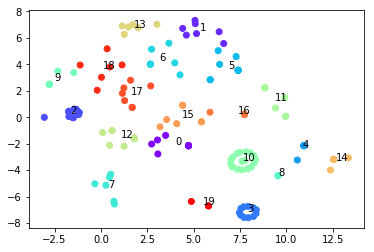

In [233]:
plt.scatter(X_sub_tsne[:,0],X_sub_tsne[:,1],c=cluster,cmap='rainbow')
for x,y in zip(km.cluster_centers_,range(0,km.cluster_centers_.shape[0])):
    plt.text(x[0],x[1],y)

In [239]:
m = km.labels_ == 10

In [240]:
np.array(sub_sentences)[m]

array([ u'the incidence of vvs and shigellosis peak the 2 week postdisaster and subsequently decrease .',
       u'the daily average precipitation interact with vvs and shigellosis incidence , whereas disaster type only interact with vvs incidence pattern .',
       u'at 4 week of starvation , m. cf .',
       u'at 10 week of starvation , only two m. cf .',
       u'result : the mean ipss and mean age for male be 13.45\xb18.24 and 75.03\xb16.20 year , respectively .',
       u'conclusion : the result indicate that much attention should be pay to unstable   weather condition in order to protect health .',
       u'in plant , lodge due to storm or herbivory cause wound stress and consequently enhance endogenous jasmonate .',
       u'elevated meja application hinder plant growth attribute under hs , cs and ot condition .',
       u'under elevate co2 plant grow large , but contain little total protein / unit of leaf area .',
       u'doi : 10.1097/01.naj.0000471240.46198.f1   pmid : 26312

In [241]:
X_sub[m]

array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0,

In [222]:
pca = PCA(n_components=3)
X_sub_pca = pca.fit_transform(X_sub)

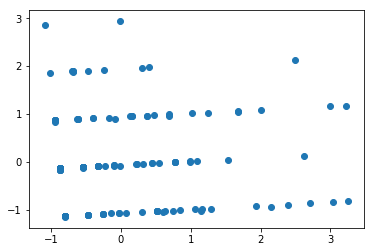

In [223]:
plt.scatter(X_sub_pca[:,0],X_sub_pca[:,1])

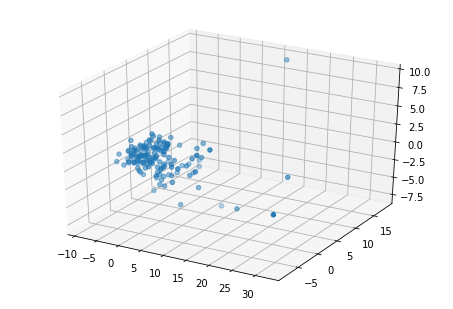

In [207]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X_sub_pca[:,0], X_sub_pca[:,1], X_sub_pca[:,2])
plt.show()

.. 별 구분 안되는데? 그럴수 밖에 없는 것이 이것은 문법을 기준으로 한 구분이다.  

In [276]:
x = np.concatenate((x_allsent_pos,x_train_sp_bow),axis=1)

In [280]:
x_allsent_pos_tsne 

array([[-16.50801086, -28.96270943],
       [-18.58210754,  20.90832901],
       [ -2.24221277,  -6.11455107],
       ..., 
       [-19.65106392,  22.50361252],
       [ -3.52474141, -18.82678986],
       [-16.23099518,  -1.74760449]], dtype=float32)

In [282]:
tsne = TSNE()
x_train_sp_bow_tsne = tsne.fit_transform(x_train_sp_bow)

In [283]:
x = np.concatenate((x_allsent_pos_tsne,x_train_sp_bow_tsne),axis = 1)

In [284]:
tsne = TSNE()
x_tsne = tsne.fit_transform(x)

In [289]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=50,random_state=0)
cluster = km.fit_predict(x_tsne)

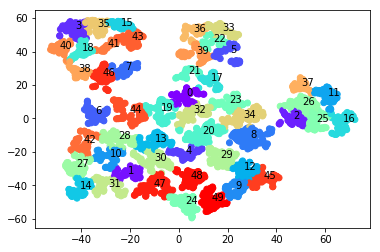

In [290]:
plt.scatter(x_tsne[:,0],x_tsne[:,1],c=cluster,cmap='rainbow')
for x,y in zip(km.cluster_centers_,range(0,km.cluster_centers_.shape[0])):
    plt.text(x[0],x[1],y)

In [291]:
m = km.labels_ == 48

In [297]:
x_train_sp_bow[m]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [292]:
np.array(sentences)[m]

array([ u'In this paper, our Food System Supply-Chain Sustainability (FoodS(3)) model connects spatial, firm-specific demand of corn purchasers with upstream corn production in the United States through a cost minimization transport model.',
       u'The combined effects of snowfall, wind speed, duration of sunshine, and cloudiness were not significant for these 3 FBD.',
       u'A meta-analysis by season showed that acute gouty arthritis occurred significantly  more frequently in spring than in other seasons.',
       u'CONCLUSIONS: Acute gouty arthritis seems to develop more frequently during the period in which the temperature increases significantly between neighboring days: spring by season and between March and July by month in the northern hemisphere.',
       u"Objective: Strategies to promote patient involvement in medical error prevention  have been implemented, but little is known about the effects of education on changes in perceptions and attitudes about patients' own safe

In [293]:
df_allsent_pos[m]

,CD-VB-VBN,DT-JJ-NN,DT-NN-VBZ,DT-NNP-NNP,IN-DT-NN,IN-NN,IN-NN-NNS,MD-PRP-VB,MD-VB-CD,MD-VB-VBN,...,VB-VBN-IN,VBZ-DT-JJ,VBZ-DT-NN,VBZ-NNP,WP-VBZ,WP-VBZ-DT,WP-VBZ-NNP,WRB-MD,WRB-MD-VB,id
165,0,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,165
216,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,216
338,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,338
342,0,1,1,0,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,342
397,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,397
406,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,406
407,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,407
409,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,409
511,0,1,1,0,0,3,1,0,0,0,...,0,0,1,0,0,0,0,0,0,511
524,0,0,0,0,1,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,524
